In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import json

# Dataset Creation from Arm-CODA dataset

Arm-Coda is a:

"dataset of 240 multivariate time series collected using 34 Cartesian Optoelectronic Dynamic Anthropometer (CODA) placed on the upper limb of 16 healthy subjects each undergoing 15 predefined movements such as raising their arms or combing their hair. Each sensor records its position in the 3D space. In total, 2.5 hours of time series are collected. A remarkable aspect of this data set is the extensive availability of metadata: subjects’ characteristics (age, height, etc.) as well as movements’ annotations. Indeed, for each subject and each movement, the start and end time stamps of at least two iterations of the same movement are provided." 

A full description of the dataset can be found on IPOL: 
http://www.ipol.im

The image below describes the the position of sensors on the upper body.



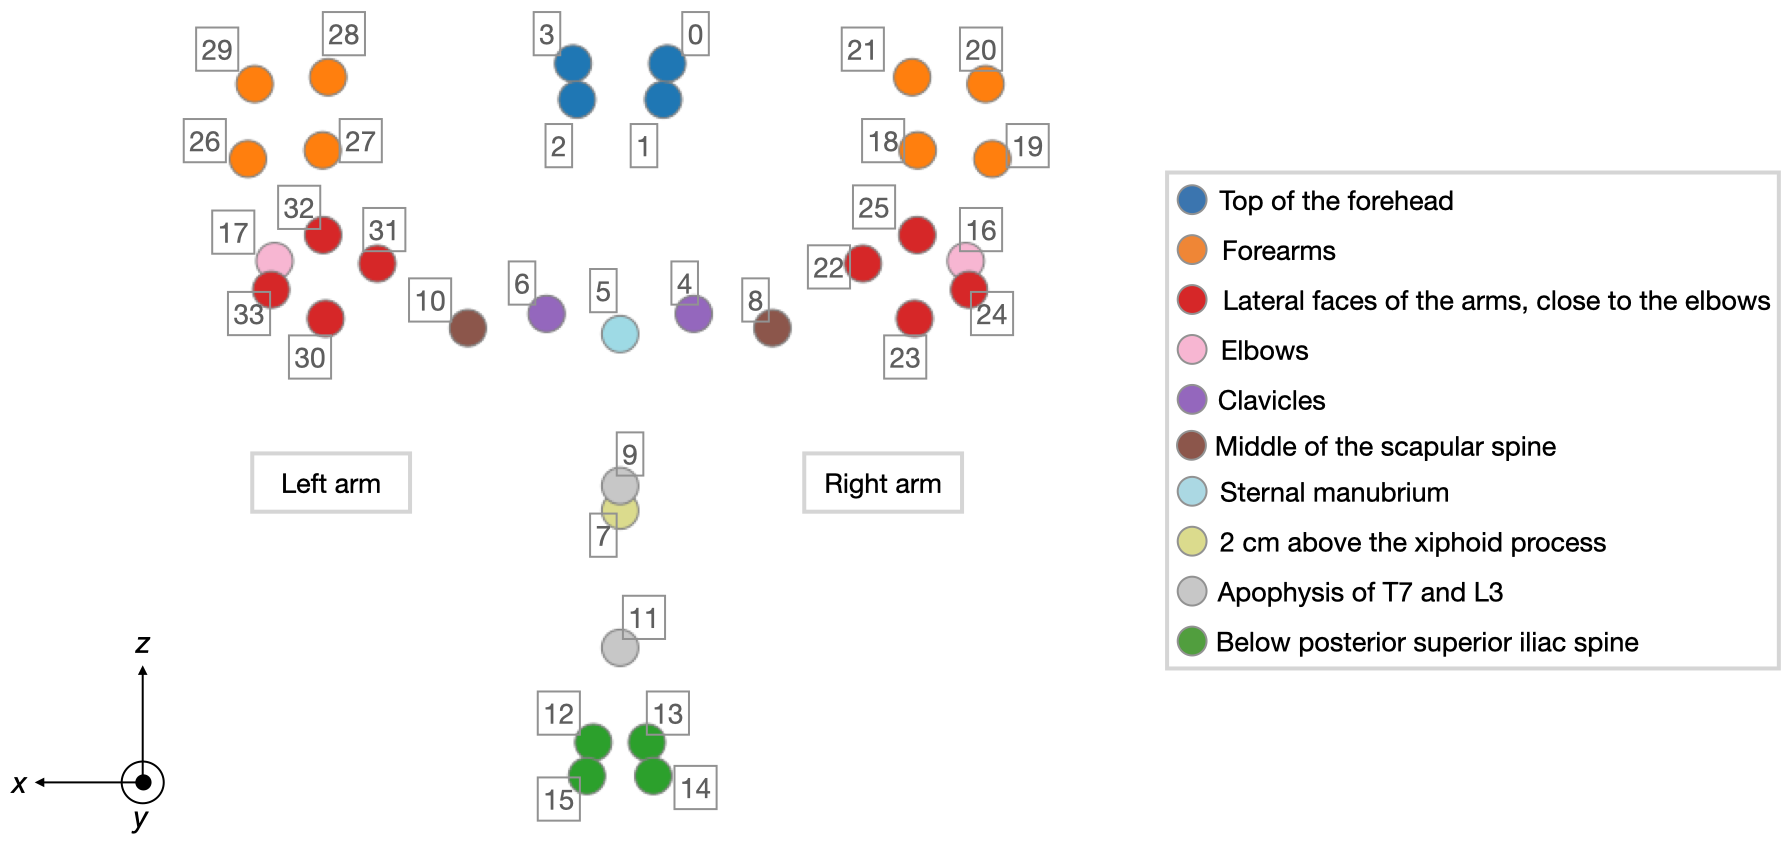

In [2]:
from IPython.display import Image
Image(filename="/Volumes/Ultra Touch/Data/arm-CODA-dataset/dataset_metadata/sensors.png")

Movements in the dataset are the following: 

0. Sagittal plane elevation (seated)
1. Scapular plane elevation (seated)
2. Frontal plane elevation (seated)
3. Scapular plane elevation with lateral wrist orientation (seated)
4. Lateral elbow rotation (seated)
5. Hair combing (seated) (right arm)
6. Hair combing (seated) (left arm)
7. Low back washing (seated) (right arm)
8. Low back washing (seated) (left arm)
9. Sagittal plane elevation (standing) 
10. Scapular plane elevation (standing)
11. Sagittal plane elevation (standing) (right arm)
12. Sagittal plane elevation (standing) (left arm)
13. Scapular plane elevation (standing) (right arm)
14. Scapular plane elevation (standing) (left arm)

Below is an illustration of each movement:

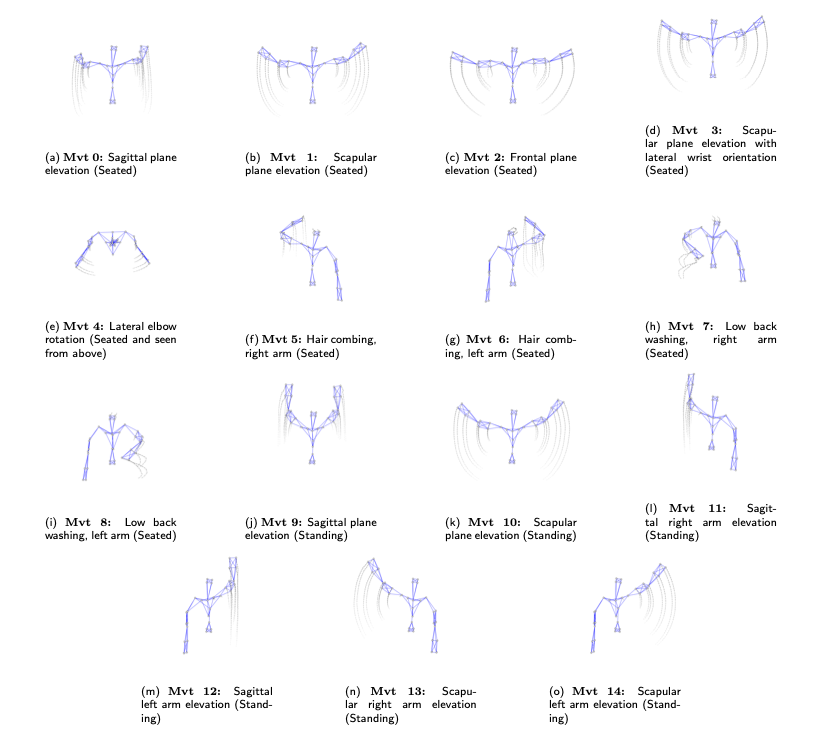

In [10]:
from IPython.display import Image
Image(filename="/Volumes/Ultra Touch/Data/arm-CODA-dataset/movements.png")

**Creation signals and labels dataset**

The construction steps of the dataset are as follow: 

1. We select two sensors of the left and right foreames and specific movements for each sensors: 
- sensor: 20, movement: 0,1,4,5,7
- sensor: 29, movement: 0,1,4,6,8

2. For each of the 16 subjects we collect the two first occurence of each movement and store all dimensions (x,y,z)
3. For each patient, sensor and dimension, we construct a signal by: 

    - successively adding movements' occurrences which are picked randomnly 
    - Between two successive movement occurrence we add a padding of zeros whose length is equal to the average movement length up to some fluctuation. 
    - We add Additive White Gaussian Noise

It results in a dataset of 96 signals composed of 5 motifs with 2 occurences. 

An example of signal and label is given in Signal Label Example Section.

## Functionnalities to extract dataset

In [3]:
def get_movement(json_filename:json,data_path:str,keep_sensor:list,downsample_factor: int= 2)->list: 
    """get the two first occurence of the movement for x,y,z dimensions

    Args:
        json_filename (json): filename of the json_file
        data_path (str): data path where are located the npy file associated to the json file
        keep_sensor (list): integer list of the sensor to keep.
        downsample_factor (int, optional): signal downsampling factor. Defaults to 2.

    Returns:
        list: list of movement pair in x,y,z dimension
    """
    with open(data_path+json_filename,"rb") as f:
        fjson = json.load(f)
    path_to_data = data_path +fjson["Data_filename"]
    data = np.load(path_to_data)
    data = np.moveaxis(data[keep_sensor],[0,1,2],[0,2,1]).reshape((-1,data.shape[1]))
    mov_lst = []
    for key, (s,e) in list(fjson["Movement_label"].items())[:2]:
        mov_lst.append(data[:,s:e])
    lst = []    
    for s1,s2 in zip(*mov_lst):  
        lst.append([s1[::downsample_factor]-s1[0],s2[::downsample_factor]-s2[0]])
    return lst
    

In [4]:
def create_signal_mask(dataset:list,length:int,keep_movement:list,fluctuation:float,signal_to_noise_ratio:float)->tuple:
    """Return signal generated and the mask associated to the signal for a sensor and a dimension. 
    A signal is the succesion of randomly picked movement occurence with period of pure noise added in between. The duration of pure noise period
    is equal to the average movement length divided by two up to some fluctuation. Additive White Gaussian Noise is also added accordingly to a certain signal to noise ratio. 

    Args:
        dataset (list): dataset corresponding of motif pairs for all the patient for one sensor and one dimension
        length (int): average length motifs length observed
        keep_movement (list): the list of movement to keep
        fluctuation (float): length fluctuation ratio, ratio in [0,1].
        signal_to_noise_ratio (float): signal to noise ratio, ratio in [0,1]

    Returns:
        tuple: signal, label mask
    """
    s_lst = []
    m_lst = []
    for mset in dataset: 
        raw_labels = []
        for i in range(len(keep_movement)): 
            raw_labels += [i,i]
        ordering = np.arange(len(raw_labels)).astype(int)
        np.random.shuffle(ordering)
        def sparsity(): 
            l = int(((2*np.random.rand(1)-1)*fluctuation +1)*length//2)
            spars = np.zeros(l)
            return spars, np.repeat(spars.reshape(1,-1),len(keep_movement),0)
        
        def motif_mask(label,size): 
            m = np.zeros((len(keep_movement),size))
            m[label] = 1
            return m
        s_z, m_z = sparsity()
        signal = [s_z]
        mask = [m_z]
        for label,motif in zip(np.array(raw_labels)[ordering],np.array(mset,dtype=object)[ordering]):
            signal.append(motif)
            mask.append(motif_mask(label,motif.shape[0]))
            s_z, m_z = sparsity()
            signal.append(s_z)
            mask.append(m_z)
        signal = np.hstack(signal)
        signal += np.random.randn(signal.shape[0])*np.std(signal)*signal_to_noise_ratio
        mask = np.hstack(mask)

        s_lst.append(signal)
        m_lst.append(mask)
    return s_lst, m_lst

In [5]:
def generating_dataset(files:list,data_path:str,keep_movement:list,keep_sensor:list,dowmnsampling:int,fluctuation:float,signal_to_noise_ratio:float)->tuple:
    """Generate a dataset which contains a signal and a label mask for each subject in the files list,sensor kept and dimensions (x,y,z). Each signal is generated
    by randomnly adding successively occurences of the 

    Args:
        files (list): list of json file including the metadata
        data_path (str): data path to the data storage of npy files.
        keep_movement (list): the list of movement to keep
        keep_sensor (list): integer list of the sensor to keep.
        dowmnsampling (int):  signal downsampling factor. Defaults to 2
        fluctuation (float): length fluctuation ratio, ratio in [0,1].
        signal_to_noise_ratio (float): signal to noise ratio, ratio in [0,1]

    Returns:
        tuple: signal dataset, label dataset.
    """
    file_indexing_df = pd.DataFrame([f.split("_")[1:] for f in files], columns= ["subject", "movement"])
    file_indexing_df["subject"] = file_indexing_df["subject"].apply(lambda x : int(x.replace("subject","")))
    file_indexing_df["movement"] = file_indexing_df["movement"].apply(lambda x : int(x.replace("movement", "").replace(".json","")))
    file_indexing_df = file_indexing_df.sort_values(["subject","movement"])
    n_subjects = file_indexing_df.subject.unique().shape[0]
    #getting motifs per sensor and dimension
    datasets = []
    for i in np.sort(file_indexing_df.subject.unique()): 
        idx = file_indexing_df[(file_indexing_df["subject"]==i)*file_indexing_df["movement"].isin(keep_movement)].index
        lsts = []
        for filename in files[idx]: 
            lsts.append(get_movement(filename,data_path,keep_sensor,dowmnsampling))
        mov_lst = []
        for lst in zip(*lsts): 
            t_lst =[]
            for l in lst: 
                t_lst += l
            mov_lst.append(t_lst)
        datasets.append(mov_lst)

    datasets = list(zip(*datasets))

    # Finding average motif length
    len_lst = []
    for d in datasets: 
        for s in d: 
            for l in s: 
                len_lst.append(len(l))
    length = np.mean(len_lst).astype(int)

    # creating one dataset per sensor and dimension
    s_datasets = []
    l_datasets = []
    for dataset in datasets: 
        s,l = create_signal_mask(dataset,length,keep_movement,fluctuation,signal_to_noise_ratio)
        s_datasets.append(s)
        l_datasets.append(l)

    X = []
    y = []
    for sd,ld in zip(s_datasets,l_datasets): 
        X += sd 
        y += ld
    return X,y

## Datasets creation

In [6]:
data_path = "/Volumes/Ultra Touch/Data/arm-CODA-dataset/dataset/"
files = [f for f in os.listdir(data_path) if 'json' in f]
files = np.sort([f for f in files if not f.startswith("._")])

In [16]:
KEEP_MOVEMENT_1 = [0,1,4,5,7]
KEEP_SENSOR_1 = [20]
KEEP_MOVEMENT_2 = [0,1,4,6,8]
KEEP_SENSOR_2 = [29]
DOWNSAMPLING = 2
SPARSITY_FLUCTUATION = 0.8 
SIGNAL_TO_NOISE_RATIO = 0.01

In [17]:
X1,y1 = generating_dataset(files,data_path,KEEP_MOVEMENT_1,KEEP_SENSOR_1,DOWNSAMPLING,SPARSITY_FLUCTUATION,SIGNAL_TO_NOISE_RATIO)
X2,y2 = generating_dataset(files,data_path,KEEP_MOVEMENT_1,KEEP_SENSOR_1,DOWNSAMPLING,SPARSITY_FLUCTUATION,SIGNAL_TO_NOISE_RATIO)
X = X1+X2
y = y1+y2

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Ultra Touch/Data/arm-CODA-dataset/dataset/armcoda_subject0_movement0.json'

## Signal Label Example

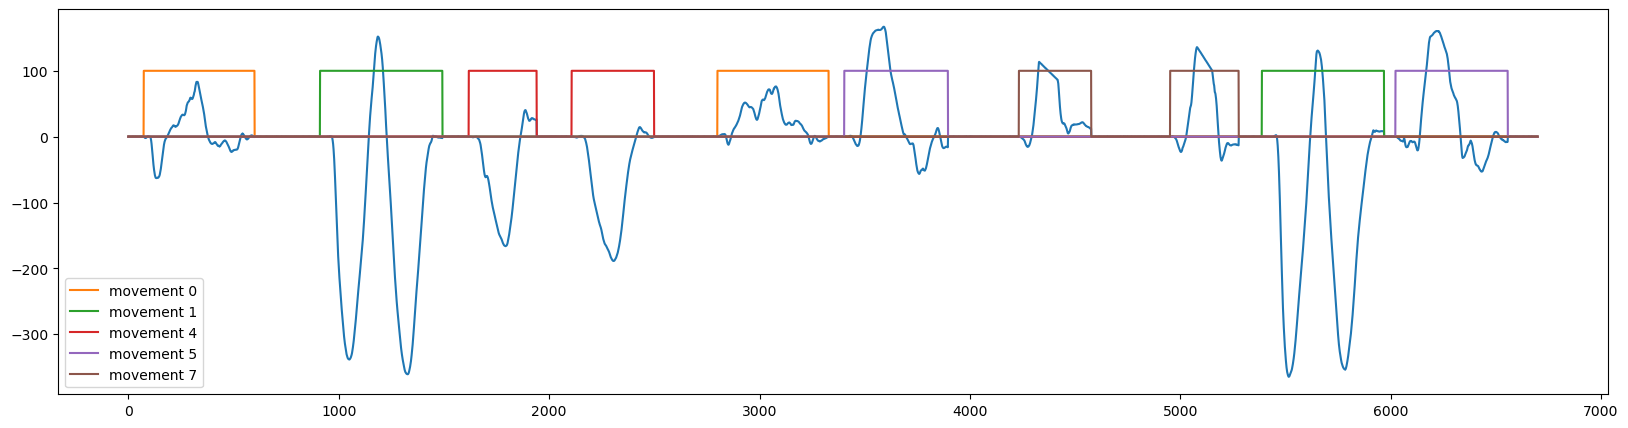

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(X[10])
for i,l in enumerate(y[10]):
    plt.plot(100*l, label = f"movement {KEEP_MOVEMENT_1[i]}")
plt.legend()